<a href="https://colab.research.google.com/github/irenezi/solid-guide/blob/master/coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import pandas as pd
import numpy as np
from pandas import read_csv, set_option
from numpy import set_printoptions
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, RFE
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier

In [8]:
def filter_constant_columns(df_data_set_x, variance=0):
  # This function filters out all the constant columns (variance = 0)
  
  constant_filter = VarianceThreshold(threshold=variance)
  constant_filter.fit(df_data_set_x)
  non_constant = constant_filter.get_support()

  columns_to_keep = (df_data_set_x.columns[constant_filter.get_support()])

  return df_data_set_x[columns_to_keep]

In [38]:
def normalize(x_train_input, x_test_input):
  # Normalize train and test data
  # Normalize the training set and save the normalization parameters
  # Normalize the test set using the training normalization parameters

  scaler=Normalizer().fit(x_train_input)
  x_train_norm=scaler.transform(x_train_input)
  x_test_norm=scaler.transform(x_test_input)
  
  return x_train_norm, x_test_norm

In [39]:
def rescale(x_train_input, x_test_input):
  # Rescale train and test data
  # Rescale the training set and save the normalization parameters
  # Rescale the test set using the training normalization parameters

  scaler=MinMaxScaler(feature_range=(0,1))
  x_train_resc=scaler.fit_transform(x_train_input)
  x_test_resc=scaler.transform(x_test_input)
  return x_train_resc, x_test_resc

In [73]:
def compare_algorithms(x_train_input, y_train_output, x_test_input, y_test_output):

  # prints the validation accuracy (using K-Folf method on the train data set)
  # and the test accuracy by apllying a variety of models to the test data set  
  
  models=[]
  models.append(('LR', LogisticRegression(solver='liblinear'))) 
  models.append(('LDA', LinearDiscriminantAnalysis()))
  #models.append(('PCA', PCA(n_components=4)))
  models.append(('KNN', KNeighborsClassifier()))
  models.append(('CART', DecisionTreeClassifier()))
  models.append(('NB', GaussianNB()))
  models.append(('SVC', SVC()))
  models.append(('LnSVC', LinearSVC()))
  val_results=[]
  test_results=[]
  names=[]

  print("Validation accuracy:")
  for name, model in models:
    kfold = KFold(n_splits=5, random_state=3, shuffle=True)
    cv_results = cross_val_score(model,x_train_input,y_train_output,cv=kfold,scoring="accuracy")
    val_results.append(cv_results)
    names.append(name)
    print("%s: %.3f (%.3f)" % (name,cv_results.mean(),cv_results.std()))

  print("Test accuracy:")
  for name, model in models:
    model.fit(x_train_input, y_train_output)
    test_prediction = model.predict(x_test_input)
    test_acc = accuracy_score(y_test_output, test_prediction)
    test_results.append(test_acc)
    print("%s: %.3f" % (name,test_acc))

  #boxplot comparison
  fig=pyplot.figure()
  ax=fig.add_subplot(111)
  ax.set_xticklabels(names)
  ax.set_ylabel("Validation_Accuracy")
  ax.set_xlabel("Classification Models")
  pyplot.boxplot(val_results)
  fig.suptitle("Algorithm Comparison")
  pyplot.show()

  fig=pyplot.figure()
  ax=fig.add_subplot(111)
  ax.set_xticklabels(names)
  ax.set_ylabel("Test_Accuracy")
  ax.set_xlabel("Classification Models")
  pyplot.boxplot(test_results)
  fig.suptitle("Algorithm Comparison")
  pyplot.show()


In [65]:
def kbest(x_train_input, y_train_output, x_test_input):
  # feature selection using K-best
  
  # apply SelectKBest class to extract top 10 best features
  bestfeatures = SelectKBest(score_func=chi2, k=10)
  fit = bestfeatures.fit(x_train_input, y_train_output)
  dfscores = pd.DataFrame(fit.scores_)
  df = pd.DataFrame(x_train_input)
  dfcolumns = pd.DataFrame(df.columns)

  # concat two dataframes for better visualization 
  featureScores = pd.concat([dfcolumns,dfscores],axis=1)
  # naming the dataframe columns
  featureScores.columns = ['Specs','Score']  
  # print 10 best features
  print(featureScores.nlargest(10,'Score'))  

  # find the 10 best features columns 
  featureScores=featureScores.values
  col=list(featureScores[:,0])
  print(col)

  # returned train data set
  features = fit.transform(x_train_input)

  # returned test data set
  df_test_features = pd.DataFrame(x_test_input)
  test_features = df_test_features[col]

  return features, test_features.values

In [66]:
def rfe_elimination(model, x_train_input, y_train_output, x_test_input):
  # apply Recursive Feature Elimination(RFE) for feature selection

  rfe=RFE(model,10)
  fit=rfe.fit(x_train_input, y_train_output)
  print("Num Features: %d" % fit.n_features_)
  print("Selected Features: %s" % fit.support_)
  print("Feature Ranking: %s" % fit.ranking_)

  dfscores = pd.DataFrame(fit.ranking_)
  df = pd.DataFrame(x_train_input)
  dfcolumns = pd.DataFrame(df.columns)

  # concat two dataframes for better visualization 
  featureScores = pd.concat([dfcolumns,dfscores],axis=1)
  # naming the dataframe columns
  featureScores.columns = ['Specs','Score']  
  print(featureScores.nsmallest(10,'Score')) 

  # find the 10 best features columns 
  featureScores=featureScores.values
  col=list(featureScores[:,0])
  print(col)

  # returned train data set
  features=fit.transform(x_train_input)

  # returned test data set
  df_test_features = pd.DataFrame(x_test_input)
  test_features = df_test_features[col]

  return features, test_features.values


In [67]:
def extra_trees_classifier(x_train_input, y_train_output, x_test_input):
  # feature selection with extra tree classifier - Feature Importance

  model = ExtraTreesClassifier()
  tree=model.fit(x_train_input,y_train_output)
  print(model.feature_importances_)
  
  print("the larger the score, the more important the attribute")

  dfscores = pd.DataFrame(tree.feature_importances_)
  df = pd.DataFrame(x_train_input)
  dfcolumns = pd.DataFrame(df.columns)
  
  # concat two dataframes for better visualization 
  featureScores = pd.concat([dfcolumns,dfscores],axis=1)
   naming the dataframe columns
  featureScores.columns = ['Specs','Score']  
  featureScores=featureScores.nlargest(10,'Score')
  
  # find the 10 best features columns 
  featureScores=featureScores.values
  col=list(featureScores[:,0])
  print(col)

  # returned train data set
  features=df[col]

  # returned test data set
  df_test_features = pd.DataFrame(x_test_input)
  test_features = df_test_features[col]

  return features.value, test_features.value


In [ ]:
#feature union(kbest-RFE logistic reg-extra tree)
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

def features_union(x_data, y_data):
  #create feature union
  
  # ('EXTRE', ExtraTreesClassifier())
  
  features=[
            ('KBEST', SelectKBest(k=10)),
            ('RFE', RFE(LogisticRegression(solver='liblinear'),10 ))
            
  ]

  # features = []
  # features.append(('pca', PCA(n_components=3)))
  # features.append(('select_best', SelectKBest(k=6)))

  union = FeatureUnion(features)
  union.fit(x_data, y_data)
  model = union.transform(x_data)
  
  return model


In [ ]:
f_union = features_union(x_train, y_train)
print(f_union.shape)


(97044, 20)


In [ ]:
#feature union(kbest-RFE logistic reg-extra tree)
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

#create feature union
features=[]
#features.append(('PCA', PCA(n_components=3)))
features.append(('KBEST', SelectKBest(k=10)))
features.append(('RFE', RFE(LogisticRegression(solver='liblinear'),10 )))
#features.append(('EXTRE', ExtraTreesClassifier()))
feature_union=FeatureUnion(features)

#create pipeline
estimators=[]
estimators.append(('feat_union', feature_union))
estimators.append(('logistic', LogisticRegression()))
model=Pipeline(estimators)

#evaluate pipeline
kfold=KFold(n_splits=5, random_state=3, shuffle=True)
results=cross_val_score(model, x_train_resc,y_train, cv=kfold)
print(results.mean())


In [ ]:
#no need to reshape!!!!
#reshape
#x_train_norm = x_train_norm.reshape((len(x_train_norm), np.prod(x_train_norm.shape[1:]))) 
#x_test_norm = x_test_norm.reshape((len(x_test_norm), np.prod(x_test_norm.shape[1:])))
#print(x_train_norm.shape)

(97044, 152)


In [ ]:
#autoencoder - 2 hidden layers
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import Adam

input_img = Input(shape=(152,))
hidden_1 = Dense(90, activation='relu')(input_img)
code = Dense(30, activation='relu')(hidden_1)
hidden_2 = Dense(90, activation='relu')(code) 
output_img = Dense(152, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_norm, x_train_norm, epochs=3)

predictions_1 = autoencoder.predict(x_test_norm)

In [ ]:
print(predictions_1.shape)
predictions_1

In [ ]:
#denoising autoencoder - same layers
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import Adam

#noise
noise_factor = 0.4
x_train_noisy = x_train_norm + noise_factor * np.random.normal(size=x_train_norm.shape)
x_test_noisy = x_test_norm + noise_factor * np.random.normal(size=x_test_norm.shape)
x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

input_img = Input(shape=(152,))
hidden_1 = Dense(90, activation='relu')(input_img)
code = Dense(30, activation='relu')(hidden_1)
hidden_2 = Dense(90, activation='relu')(code) 
output_img = Dense(152, activation='sigmoid')(hidden_2)

autoencoder_noisy = Model(input_img, output_img)
autoencoder_noisy.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_noisy.fit(x_train_noisy, x_train_norm, epochs=3)

predictions_2 = autoencoder_noisy.predict(x_test_noisy)

In [ ]:
#without regularization (not sparsed)
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import Adam

input_size = 152
code_size = 30

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu')(input_img) 
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder_standard = Model(input_img, output_img) 
autoencoder_standard.compile(optimizer='adam', loss='binary_crossentropy') 
history_standard = autoencoder_standard.fit(x_train_norm, x_train_norm, epochs=3)
encoded_standard = Model(input_img, code)

predictions_3 = autoencoder_standard.predict(x_test_norm)

In [ ]:
#sparse autoencoder with regularization
from keras.regularizers import l1

input_size = 152
code_size = 30

input_img = Input(shape=(input_size,))
code = Dense(code_size,activity_regularizer=l1(10e-4), activation='relu')(input_img) 
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder_regularized = Model(input_img, output_img) 
autoencoder_regularized.compile(optimizer='adam', loss='binary_crossentropy') 
history_regularized = autoencoder_regularized.fit(x_train_norm, x_train_norm, epochs=3)
encoded_regularized = Model(input_img, code)

predictions_4 = autoencoder_regularized.predict(x_test_norm)

In [ ]:
autoencoder.evaluate(x_test_norm, x_test_norm)
autoencoder_noisy.evaluate(x_test_norm, x_test_norm)
autoencoder_standard.evaluate(x_test_norm, x_test_norm)
autoencoder_regularized.evaluate(x_test_norm, x_test_norm)

print(predictions_1.mean())
#print(autoencoder.predict(x_test_norm).mean()) - same
print(predictions_2.mean())
print(predictions_3.mean()) 
print(predictions_4.mean())

In [ ]:
#not ready!!
import matplotlib.pyplot as plt

# plot loss
plt.plot(history_standard.history['loss'], label='train')
plt.plot(history_standard.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
#reduced train dataset
import numpy as np
number_of_rows = train_data_array.shape[0]
print(number_of_rows)
random_indices = np.random.choice(number_of_rows,size=600, replace=False)
random_rows = train_data_array[random_indices, :]

X=random_rows[:,0:152]
Y=random_rows[:,152]

In [ ]:
#GRID SEARCH FOR NN

# MLP for Pima Indians Dataset with grid search via sklearn

from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

#numpy.set_printoptions(precision=3)


# create a function to build a model
#required for KerasClassifier
def create_model_2(init="glorot_uniform", optimizer="rmsprop"):
  model=Sequential()
  model.add(Dense(150, input_dim=152, activation="relu", kernel_initializer=init))
  model.add(Dense(50, activation="relu", kernel_initializer=init))
  model.add(Dense(1, activation="softmax", kernel_initializer=init))

  model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

  return model

# create model
model_2=KerasClassifier(build_fn=create_model_2, verbose=0)

#grid search to find epochs, batch_size, optimizer
epochs_list=[50,100,150,200]
batches_list=[5,10,15]
optimizer_list=["adam", "rmsprop"]
inits_list=["glorot_uniform","normal", "uniform"]

param_grid_dictionary=dict(optimizer=optimizer_list, epochs=epochs_list, batch_size=batches_list, init=inits_list)
type(param_grid_dictionary)
grid=GridSearchCV(estimator=model_2,param_grid=param_grid_dictionary)
grid_result=grid.fit(X,Y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

#best result 0,5033, epochs=50, batches=5, optimizer="adam", inits="glorot_uniform"


In [ ]:
#GRID SEARCH FOR CNN

# MLP for Pima Indians Dataset with grid search via sklearn

from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

#numpy.set_printoptions(precision=3)


# create a function to build a model
#required for KerasClassifier
def create_model_CNN(init="glorot_uniform", optimizer="rmsprop"):
  model=Sequential()
  model.add(Conv2D(32,kernel_size=(5,5), strides=(1,1), padding="same", activation="relu", input_shape=(1,152,600)))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(64,(2,2),activation="relu",padding="same"))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0,25))
  model.add(Flatten())
  model.add(Dense(1000, activation="relu"))
  model.add(Dropout(0,5))
  model.add(Dense(2, activation="softmax"))

  model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

  return model

# create model
model_CNN=KerasClassifier(build_fn=create_model_CNN, verbose=0)

#grid search to find epochs, batch_size, optimizer
epochs_list=[100,150]
batches_list=[5,10]
optimizer_list=["adam", "rmsprop"]
inits_list=["glorot_uniform","normal", "uniform"]

param_grid_dictionary=dict(optimizer=optimizer_list, epochs=epochs_list, batch_size=batches_list, init=inits_list)
type(param_grid_dictionary)
grid=GridSearchCV(estimator=model_CNN,param_grid=param_grid_dictionary)
grid_result=grid.fit(X,Y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))
  

In [ ]:
compare_algorithms(x_train, y_train)  

In [ ]:
compare_algorithms(x_train_norm, y_train)  

In [ ]:
compare_algorithms(x_train_resc, y_train)

MAY NOT BE NEEDED

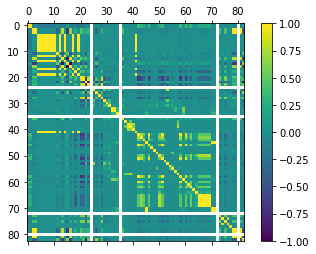

In [34]:
#correlation matrix plot
correlations=df_train_data_filtered.corr()
fig=pyplot.figure()
ax=fig.add_subplot(1,1,1)
cax=ax.matshow(correlations,vmin=-1, vmax=1)
fig.colorbar(cax)
pyplot.show()

In [ ]:
df_train_data_filtered.corr(method="pearson")

In [ ]:
#scatter plot matrix
scatter_matrix(train_data, figsize=[20,20])
pyplot.show()

In [ ]:
set_option("display.width",100)
set_option("precision",2)
train_data.describe()

set_printoptions(precision=3)

In [ ]:
#check if balanced
train_data.groupby("155").size()
test_data.groupby("155").size()

In [ ]:
#check for skew
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

results_skew = train_data.skew()
print(results_skew)

In [ ]:
print(np.max(x_test_norm))
np.min(x_test_norm)

In [ ]:
from sklearn.svm import SVR, SVC, LinearSVC
rfe_elimination(SVR(kernel="linear"), x_train, y_train)
rfe_elimination(SVC(), x_train, y_train)
rfe_elimination(LinearSVC(), x_train, y_train)

RUN

DEALING WITH THE DATA

In [36]:
#load the data
filename1 ="train_imperson_without4n7_balanced_data.csv"
filename2 ="test_imperson_without4n7_balanced_data.csv"

df_train_data = read_csv(filename1)
df_test_data = read_csv(filename2)


# apply constant column filter

# not matched constant columns in the train and test data set

# merge them to one data set
df_full_data = df_train_data.append(df_test_data)

#apply the filter
df_full_data_filtered = filter_constant_columns(df_full_data)

# separate the data sets
df_train_data_filtered = df_full_data_filtered[0:97044]
df_test_data_filtered = df_full_data_filtered[97044:]


#separate the filtered x,y
x_train = df_train_data_filtered[df_train_data_filtered.columns[:-1]].values
y_train = df_train_data_filtered[df_train_data_filtered.columns[-1]].values
x_test = df_test_data_filtered[df_test_data_filtered.columns[:-1]].values
y_test = df_test_data_filtered[df_test_data_filtered.columns[-1]].values

In [40]:
x_train_norm, x_test_norm = normalize(x_train, x_test)

In [41]:
x_train_resc, x_test_resc = rescale(x_train, x_test)

FITTING MODELS TO COMPARE, USING: Raw data / Normalized data / Rescaled data

Validation accuracy:
LR: 0.992 (0.001)
LDA: 0.985 (0.002)
KNN: 0.999 (0.000)
CART: 1.000 (0.000)
NB: 0.978 (0.001)
SVC: 0.995 (0.001)
LnSVC: 0.995 (0.001)
Test accuracy:
LR: 0.868
LDA: 0.931
KNN: 0.534
CART: 0.414
NB: 0.500
SVC: 0.530
LnSVC: 0.652


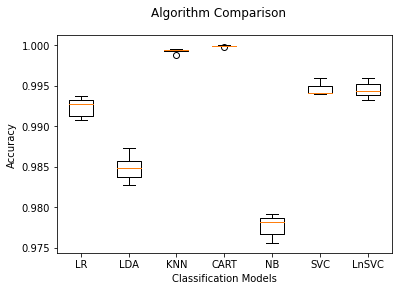

In [61]:
# fitting models to raw data
compare_algorithms(x_train, y_train, x_test, y_test)

In [ ]:
# fitting models to normalized data
compare_algorithms(x_train_norm, y_train, x_test_norm, y_test)

Validation accuracy:
LR: 0.988 (0.001)
LDA: 0.985 (0.002)
KNN: 0.999 (0.000)
CART: 1.000 (0.000)
NB: 0.986 (0.001)


Validation accuracy:
LR: 0.995 (0.001)
LDA: 0.985 (0.002)
KNN: 1.000 (0.000)
CART: 1.000 (0.000)
NB: 0.987 (0.001)
SVC: 0.997 (0.001)
LnSVC: 0.997 (0.001)
Test accuracy:
LR: 0.506
LDA: 0.931
KNN: 0.536
CART: 0.414
NB: 0.500
SVC: 0.499
LnSVC: 0.509


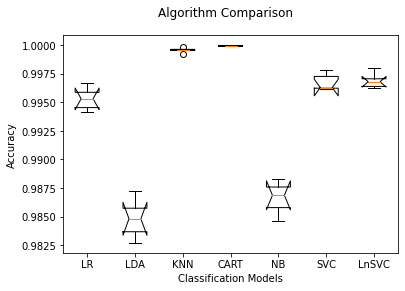

In [72]:
# fitting models to rescaled data
compare_algorithms(x_train_resc, y_train, x_test_resc, y_test)

FEATURE SELECTION (TOP 10 FEATURES) USING: K-BEST / RFE / EXTRA TREES, MODELS EVALUATION

In [70]:
# K-Best method for rescaled data
kbest_features_resc=kbest(x_train_resc, y_train)
print(kbest_features_resc)

    Specs         Score
26     26  32124.682195
16     16  28936.000138
22     22  28321.490224
13     13  24346.021809
81     81  13311.733744
15     15  12317.666392
2       2  12076.290588
3       3  12076.290588
23     23   7911.296191
36     36   7720.479234
[[0.0091503 0.0091503 0.88679   ... 1.        0.94628   0.       ]
 [0.        0.        0.43396   ... 0.        0.        0.       ]
 [0.070588  0.070588  0.        ... 0.        0.25543   0.       ]
 ...
 [0.038562  0.038562  0.        ... 0.        0.21856   0.       ]
 [0.038562  0.038562  0.        ... 0.        0.2188    0.       ]
 [0.038562  0.038562  0.        ... 0.        0.21905   0.       ]]


In [71]:
# compare models using top 10 features from K-Best
compare_algorithms(kbest_features_resc, y_train)

TypeError: ignored

In [ ]:
# Recursive Feature Elimination method for rescaled data
rfe_features_resc=rfe_elimination(LogisticRegression(solver='liblinear'), x_train_resc, y_train)
print(rfe_features_resc)

In [ ]:
# compare models using top 10 features from RFE
compare_algorithms(rfe_features_resc, y_train)

In [ ]:
# Extra Trees Classifier mathod for rescaled data
extree_features_resc=extra_trees_classifier(x_train_resc, y_train)
print(extree_features_resc)